<a href="https://colab.research.google.com/github/tb000330/BPA_Lab/blob/main/Abnomal%20Detection/IF_threshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import datetime
import random

from tqdm import tqdm

from IPython.display import display
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import matplotlib.dates as dates
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D

from scipy import signal
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

# #1. 전처리

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/학교/LAB/항법세트.csv')
df = df.drop(['사업장명', '검사구분', '자재코드', '자재명', '샘플번호', '검사키'], axis=1)

str_list = ['식별번호 일치여부', '부품 정상조립 여부', '보호피막 처리 누락 및 결함여부', 'S/W 버전 확인_PC전시화면', 'S/W 버전 확인_시험 프로그램', '초기고장배제 진동시험, 온도시험']

# 검사항목 pass/unpass drop
for s in str_list:
    df = df[df['검사항목']!=s]
df = df.reset_index(drop=True)

standard = df[['상한값', '하한값', '검사항목']][14:28].reset_index(drop=True)
standard['검사항목'] = ['pe_repeat','pe_head','pe_roll','pe_pitch', 'att_roll', 'att_pitch', 'att_head', 'set_0', 'set_90', 'set_180', 'set_270',  'weight', 'voltage', 'current']
standard = standard.fillna(0)

## 2. 검사항목 별 검사값 상관계수
df = df[['검사요청번호', '검사항목', '검사값']]
df_cor = df.pivot_table(index='검사요청번호', columns='검사항목', values='검사값')
df_cor.columns = ['pe_head', 'att_head', 'pe_pitch', 'att_pitch', 'pe_roll', 'att_roll', 'current', 'voltage', 'pe_repeat', 'weight', 'set_0', 'set_180', 'set_90', 'set_270']
df_cor

,pe_head,att_head,pe_pitch,att_pitch,pe_roll,att_roll,current,voltage,pe_repeat,weight,set_0,set_180,set_90,set_270
검사요청번호,,,,,,,,,,,,,,
OQ-20201006-00022,0.016,0.237,0.044,0.096,0.059,0.114,2.180,28.007,0.286,17.66,271.300,700.200,586.500,877.800
OQ-20201029-00010,0.017,0.210,0.037,0.077,0.061,0.087,2.168,28.006,0.098,17.66,325.730,904.770,182.040,409.610
OQ-20201029-00011,0.021,0.265,0.043,0.141,0.064,0.200,2.178,28.007,0.275,17.68,333.370,1034.720,250.470,934.750
OQ-20201112-00005,0.018,0.423,0.039,0.144,0.056,0.200,2.197,28.011,0.193,17.68,365.491,1388.559,444.647,1093.227
OQ-20201119-00011,0.019,0.202,0.046,0.090,0.063,0.114,2.198,28.006,0.385,17.71,430.241,1169.491,399.156,1798.777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OQ-20220705-00008,0.020,0.160,0.010,0.100,0.000,0.150,2.200,28.000,0.410,17.80,789.100,1238.900,755.400,1173.600
OQ-20220705-00009,0.020,0.250,0.000,0.110,0.000,0.170,2.100,28.000,0.210,17.70,291.700,1632.300,415.300,2320.300
OQ-20220718-00008,0.010,0.200,0.000,0.050,0.000,0.070,2.200,28.000,0.280,17.80,548.400,2322.200,549.600,1882.500


In [ ]:
df_cor = df_cor.reset_index()
df_cor['datetime'] = df_cor['검사요청번호'].str.slice(start=3, stop=11)
df_cor['datetime'] = pd.to_datetime(df_cor['datetime'], format='%Y%m%d')
df_cor

,검사요청번호,pe_head,att_head,pe_pitch,att_pitch,pe_roll,att_roll,current,voltage,pe_repeat,weight,set_0,set_180,set_90,set_270,datetime
0,OQ-20201006-00022,0.016,0.237,0.044,0.096,0.059,0.114,2.180,28.007,0.286,17.66,271.300,700.200,586.500,877.800,2020-10-06
1,OQ-20201029-00010,0.017,0.210,0.037,0.077,0.061,0.087,2.168,28.006,0.098,17.66,325.730,904.770,182.040,409.610,2020-10-29
2,OQ-20201029-00011,0.021,0.265,0.043,0.141,0.064,0.200,2.178,28.007,0.275,17.68,333.370,1034.720,250.470,934.750,2020-10-29
3,OQ-20201112-00005,0.018,0.423,0.039,0.144,0.056,0.200,2.197,28.011,0.193,17.68,365.491,1388.559,444.647,1093.227,2020-11-12
4,OQ-20201119-00011,0.019,0.202,0.046,0.090,0.063,0.114,2.198,28.006,0.385,17.71,430.241,1169.491,399.156,1798.777,2020-11-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,OQ-20220705-00008,0.020,0.160,0.010,0.100,0.000,0.150,2.200,28.000,0.410,17.80,789.100,1238.900,755.400,1173.600,2022-07-05
77,OQ-20220705-00009,0.020,0.250,0.000,0.110,0.000,0.170,2.100,28.000,0.210,17.70,291.700,1632.300,415.300,2320.300,2022-07-05
78,OQ-20220718-00008,0.010,0.200,0.000,0.050,0.000,0.070,2.200,28.000,0.280,17.80,548.400,2322.200,549.600,1882.500,2022-07-18
79,OQ-20220718-00009,0.020,0.250,0.010,0.110,0.000,0.140,2.200,28.000,0.170,17.70,563.300,2288.600,512.600,1328.800,2022-07-18


## (1) padding 시간단위

In [ ]:
df_num = pd.DataFrame()

for date in df_cor['datetime'].unique():
  date_i = df_cor[df_cor['datetime']==date].reset_index(drop=True).reset_index()
  date_i['index'] = date_i['index'].astype(str)

  date_i['datetime_num'] = date_i['검사요청번호'].str.slice(start=3, stop=11) + '0' + date_i['index']
  df_num = df_num.append(date_i)

df_num = df_num.drop(['index'], axis=1).reset_index(drop=True)

df_num['datetime_num'] = pd.to_datetime(df_num['datetime_num'], format='%Y%m%d%H')
df_num = df_num[['검사요청번호'	,'pe_head'	,'att_head',	'pe_pitch',	'att_pitch'	,'pe_roll'	,'att_roll',	'current'	,'voltage'	,'pe_repeat',	'weight'	,'set_0'	,'set_180'	,'set_90',	'set_270',	'datetime_num','datetime']]

In [ ]:
df_num_pad = df_num.set_index('datetime_num').asfreq('H', method='pad')
df_num_pad[df_num_pad['datetime']=='2020-10-29']

,검사요청번호,pe_head,att_head,pe_pitch,att_pitch,pe_roll,att_roll,current,voltage,pe_repeat,weight,set_0,set_180,set_90,set_270,datetime
datetime_num,,,,,,,,,,,,,,,,
2020-10-29 00:00:00,OQ-20201029-00010,0.017,0.210,0.037,0.077,0.061,0.087,2.168,28.006,0.098,17.66,325.73,904.77,182.04,409.61,2020-10-29
2020-10-29 01:00:00,OQ-20201029-00011,0.021,0.265,0.043,0.141,0.064,0.200,2.178,28.007,0.275,17.68,333.37,1034.72,250.47,934.75,2020-10-29
2020-10-29 02:00:00,OQ-20201029-00011,0.021,0.265,0.043,0.141,0.064,0.200,2.178,28.007,0.275,17.68,333.37,1034.72,250.47,934.75,2020-10-29
2020-10-29 03:00:00,OQ-20201029-00011,0.021,0.265,0.043,0.141,0.064,0.200,2.178,28.007,0.275,17.68,333.37,1034.72,250.47,934.75,2020-10-29
2020-10-29 04:00:00,OQ-20201029-00011,0.021,0.265,0.043,0.141,0.064,0.200,2.178,28.007,0.275,17.68,333.37,1034.72,250.47,934.75,2020-10-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-11 19:00:00,OQ-20201029-00011,0.021,0.265,0.043,0.141,0.064,0.200,2.178,28.007,0.275,17.68,333.37,1034.72,250.47,934.75,2020-10-29
2020-11-11 20:00:00,OQ-20201029-00011,0.021,0.265,0.043,0.141,0.064,0.200,2.178,28.007,0.275,17.68,333.37,1034.72,250.47,934.75,2020-10-29
2020-11-11 21:00:00,OQ-20201029-00011,0.021,0.265,0.043,0.141,0.064,0.200,2.178,28.007,0.275,17.68,333.37,1034.72,250.47,934.75,2020-10-29


## (2) 중복 datetime 다른 날짜로 분리

In [ ]:
# df_dup = df_cor.copy()
# df_dup['datetime'] = df_dup['datetime'].astype(str)
# dup_date = pd.DataFrame(df_dup.groupby(['datetime']).count())
# dup_date = dup_date[dup_date['검사요청번호']>1].reset_index()['datetime']
# dup_date

In [ ]:
# for date in dup_date.values:
#   date_index = df_dup[df_dup['datetime'] == date].index
#   for ind in range(len(date_index)):
#     if ind == 0:
#       pass
#     else:
#       dup_index = date_index[ind]
#       df_dup['datetime'][dup_index] = str(pd.to_datetime(date)+pd.DateOffset(days=ind))[:10]

# # 중복날짜 없는 지 확인
# (df_dup.groupby('datetime')['datetime'].count() > 1).unique()

In [ ]:
# df_dup['datetime'] = pd.to_datetime(df_dup['datetime'])
# df_dup

In [ ]:
# group1 = df_dup[['pe_repeat','att_head', 'datetime']]
# group2 = df_dup[['pe_head','pe_pitch','pe_roll', 'datetime']]
# group3 = df_dup[['att_pitch', 'att_roll', 'datetime']]
# group4 = df_dup[['set_0','set_90', 'datetime']]
# group5 = df_dup[['set_180', 'set_270', 'datetime']]
# group6 = df_dup[['current', 'datetime']]
# group7 = df_dup[['voltage', 'datetime']]
# group8 = df_dup[['weight', 'datetime']]

## (3) 상관관계

In [ ]:
df_num.corr(method='pearson')

,pe_head,att_head,pe_pitch,att_pitch,pe_roll,att_roll,current,voltage,pe_repeat,weight,set_0,set_180,set_90,set_270
pe_head,1.000000,-0.134285,0.038843,-0.036506,-0.017810,-0.034870,-0.059390,-0.128709,-0.061265,0.046910,0.056097,0.010547,0.112893,-0.120901
att_head,-0.134285,1.000000,0.068467,0.414388,0.104822,0.345653,0.086073,0.085250,0.066906,-0.171648,-0.061532,0.157021,0.167591,0.029178
pe_pitch,0.038843,0.068467,1.000000,0.013995,0.968736,-0.078624,0.237847,0.267870,-0.006799,-0.457198,-0.116934,0.163562,-0.077100,0.121748
att_pitch,-0.036506,0.414388,0.013995,1.000000,0.002308,0.960810,-0.089238,0.039908,0.114537,-0.182366,-0.123451,-0.026061,0.047226,0.006031
pe_roll,-0.017810,0.104822,0.968736,0.002308,1.000000,-0.103833,0.218505,0.320142,-0.029204,-0.425309,-0.126235,0.151931,-0.081699,0.089636
att_roll,-0.034870,0.345653,-0.078624,0.960810,-0.103833,1.000000,-0.081819,-0.032482,0.078933,-0.162815,-0.121437,-0.040674,0.061060,0.016418
current,-0.059390,0.086073,0.237847,-0.089238,0.218505,-0.081819,1.000000,0.095071,0.061431,-0.320327,0.219890,0.246957,0.134822,0.212940
voltage,-0.128709,0.085250,0.267870,0.039908,0.320142,-0.032482,0.095071,1.000000,0.092878,0.026038,-0.142567,0.036721,-0.151064,0.046233
pe_repeat,-0.061265,0.066906,-0.006799,0.114537,-0.029204,0.078933,0.061431,0.092878,1.000000,-0.038647,0.164696,-0.014912,0.069561,0.033028
weight,0.046910,-0.171648,-0.457198,-0.182366,-0.425309,-0.162815,-0.320327,0.026038,-0.038647,1.000000,0.088328,-0.109533,-0.069946,-0.054024


# #2. Isolation

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

## #(1) 단일 변수

In [ ]:
df_num = df_num.iloc[:,1:]

In [ ]:
def univar_isolation_forest(df,columns,ratio):
  group_result = pd.DataFrame()
  
  group = df[[columns, 'datetime_num']].set_index('datetime_num')
  outliers_fraction = float(ratio) # 이상치 비율설정

  #표준화
  scaler = StandardScaler()
  np_scaled = scaler.fit_transform(group.values.reshape(-1, 1))
  data = pd.DataFrame(np_scaled)

  # 학습 및 예측
  model = IsolationForest(contamination=outliers_fraction)
  IF_model = model.fit(data)

  group_result.index = group.index
  group_result['X'] = group[columns]
  group_result['pred_y'] = model.predict(data)
  group_result['decision_function'] = model.decision_function(data)
  group_result['score_samples'] = model.score_samples(data)
  group_result['offset'] = model.decision_function(data) - model.score_samples(data)
  group_result['col'] = str(columns)

  return group_result

In [ ]:
isolation_result = pd.DataFrame()

for col in df_num.columns[0:14]:
  df_col = pd.DataFrame()
  df_col = univar_isolation_forest(df_num, col, .05)

  isolation_result = pd.concat([isolation_result,df_col], axis=0)

isolation_result#.sort_values(by=['col','score_samples']).head(10)

,X,pred_y,decision_function,score_samples,offset,col
datetime_num,,,,,,
2020-10-06 00:00:00,0.016,1,0.037879,-0.599181,0.637060,pe_head
2020-10-29 00:00:00,0.017,1,0.029427,-0.607633,0.637060,pe_head
2020-10-29 01:00:00,0.021,-1,-0.016591,-0.653651,0.637060,pe_head
2020-11-12 00:00:00,0.018,1,0.092827,-0.544234,0.637060,pe_head
2020-11-19 00:00:00,0.019,1,0.101846,-0.535214,0.637060,pe_head
...,...,...,...,...,...,...
2022-07-05 01:00:00,1173.600,1,0.204697,-0.411392,0.616088,set_270
2022-07-05 02:00:00,2320.300,1,0.031626,-0.584462,0.616088,set_270
2022-07-18 00:00:00,1882.500,1,0.139922,-0.476166,0.616088,set_270


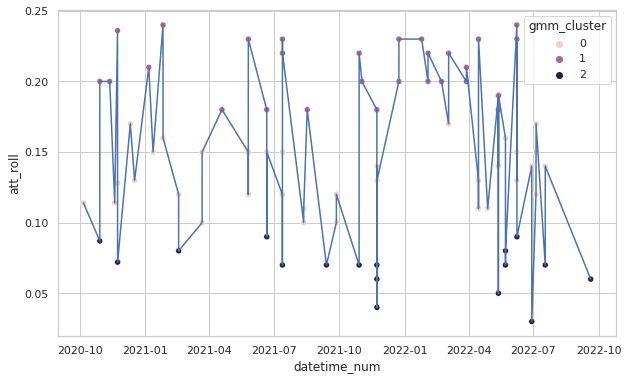

In [ ]:
group = df_num[['att_roll', 'datetime_num']].set_index('datetime_num')

scaler = StandardScaler()
np_scaled = scaler.fit_transform(group.values.reshape(-1, 1))

gmm = GaussianMixture(n_components=3, random_state=0).fit(np_scaled)
group['gmm_cluster'] = gmm.predict(np_scaled)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(group.index, group['att_roll'])
sns.scatterplot(group.index, group['att_roll'], hue=group['gmm_cluster'])

# ax.scatter(anomal_point.index, anomal_point['X'], s=s, color='red', label = 'Anomaly')

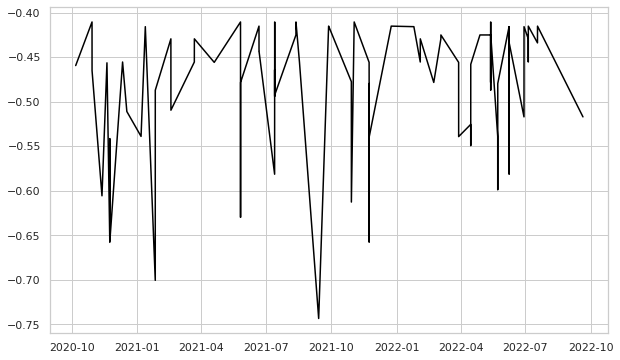

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(isolation_result[isolation_result['col']=='att_head'].index, isolation_result[isolation_result['col']=='att_head']['score_samples'], color='black', label = 'Normal')

In [ ]:
## 이상치 판정계산 과정

# np.percentile(self.score_samples(X), 100.0 * self.contamination)
offset = np.percentile(isolation_result[isolation_result['col']=='att_head']['score_samples'].values, 100.0 * 0.05)
print(offset)
# decision_function = score_samples - offset (offset보다 작은 값은 음수가 되므로, 그 음수들이 이상치)
decision_function	 = isolation_result[isolation_result['col']=='att_head']['score_samples'].values - offset
decision_function

-0.6564251277831623


array([ 0.19728324,  0.24625233,  0.19157958,  0.0509679 ,  0.20034317,
       -0.00136885,  0.11525745,  0.        ,  0.20126405,  0.14565562,
        0.11771271,  0.24097331, -0.0440237 ,  0.16956753,  0.22730102,
        0.14713461,  0.20126405,  0.22730102,  0.20087728,  0.24625233,
        0.02674709,  0.17832269,  0.24157702,  0.21321455,  0.21321455,
        0.07519664,  0.1925449 ,  0.16269725,  0.24625233,  0.16430477,
        0.23166105,  0.24625233,  0.20087728, -0.08684556,  0.24157702,
        0.24157702,  0.1792535 ,  0.04393271,  0.24625233,  0.20087728,
        0.16956753, -0.00114664,  0.17710045,  0.13963235,  0.11747186,
        0.24097331,  0.24157702,  0.24097331,  0.20126405,  0.22730102,
        0.17832269,  0.22730102,  0.23166105,  0.20087728,  0.11747186,
        0.13116673,  0.10722011,  0.19871599,  0.23166105,  0.23166105,
        0.1792535 ,  0.17832269,  0.24625233,  0.16956753,  0.23166105,
        0.11771271,  0.05766264,  0.17710045,  0.24097331,  0.14

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN


score_test = pd.DataFrame(isolation_result[isolation_result['col']=='att_head']['score_samples'])

gmm = GaussianMixture(n_components=3, random_state=0).fit(score_test['score_samples'].values.reshape(-1, 1))
dbscan = DBSCAN(eps=0.03)

score_test['gmm_cluster'] = gmm.predict(score_test['score_samples'].values.reshape(-1, 1))
score_test['dbscan_cluster'] = dbscan.fit_predict(score_test['score_samples'].values.reshape(-1, 1))

score_test['pred_y'] = isolation_result[isolation_result['col']=='att_head']['pred_y']
score_test

,score_samples,gmm_cluster,dbscan_cluster,pred_y
datetime_num,,,,
2020-10-06 00:00:00,-0.459142,0,0,1
2020-10-29 00:00:00,-0.410173,1,0,1
2020-10-29 01:00:00,-0.464846,0,0,1
2020-11-12 00:00:00,-0.605457,2,1,1
2020-11-19 00:00:00,-0.456082,0,0,1
...,...,...,...,...
2022-07-05 01:00:00,-0.455161,0,0,1
2022-07-05 02:00:00,-0.414848,1,0,1
2022-07-18 00:00:00,-0.433679,0,0,1


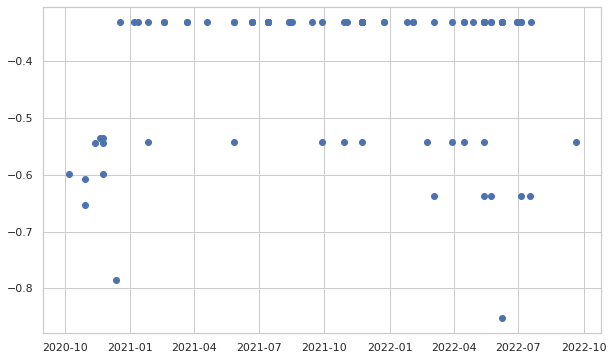

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
gmm = GaussianMixture(n_components=3, random_state=0).fit(score_test['score_samples'].values.reshape(-1, 1))
sns.scatterplot(score_test.index, score_test['score_samples'], hue=score_test['gmm_cluster'])

In [ ]:
isolation_result[isolation_result['col']=='pe_head'].sort_values(by='X')

,X,pred_y,decision_function,score_samples,offset,col
datetime_num,,,,,,
2022-07-18 00:00:00,0.01,1,0.000000,-0.637060,0.63706,pe_head
2022-07-05 00:00:00,0.01,1,0.000000,-0.637060,0.63706,pe_head
2022-05-13 03:00:00,0.01,1,0.000000,-0.637060,0.63706,pe_head
2022-05-23 01:00:00,0.01,1,0.000000,-0.637060,0.63706,pe_head
2022-03-04 01:00:00,0.01,1,0.000000,-0.637060,0.63706,pe_head
...,...,...,...,...,...,...
2021-10-29 00:00:00,0.03,1,0.095061,-0.542000,0.63706,pe_head
2021-11-23 03:00:00,0.03,1,0.095061,-0.542000,0.63706,pe_head
2022-09-20 00:00:00,0.03,1,0.095061,-0.542000,0.63706,pe_head


In [ ]:
isolation_result[isolation_result['decision_function']<0]

,X,pred_y,decision_function,score_samples,offset,col
datetime_num,,,,,,
2020-10-29 01:00:00,0.021,-1,-0.015746,-0.647271,0.631525,pe_head
2020-12-11 00:00:00,0.050,-1,-0.166880,-0.798405,0.631525,pe_head
2022-06-08 02:00:00,0.070,-1,-0.221625,-0.853151,0.631525,pe_head
2020-11-23 00:00:00,0.484,-1,-0.032634,-0.686021,0.653387,att_head
2020-11-23 02:00:00,0.052,-1,-0.002115,-0.655502,0.653387,att_head
...,...,...,...,...,...,...
2022-07-05 00:00:00,119.000,-1,-0.003203,-0.595455,0.592252,set_90
2021-07-13 00:00:00,2242.300,-1,-0.027650,-0.645354,0.617704,set_270
2021-08-12 00:00:00,0.000,-1,-0.142623,-0.760327,0.617704,set_270


In [ ]:
print(isolation_result[(isolation_result['col']=='att_roll')&(isolation_result['pred_y']==1)]['score_samples'].mean())
isolation_result[isolation_result['col']=='att_roll']#.sort_values(by='score_samples')

-0.5006004984479386


,X,pred_y,decision_function,score_samples,offset,col
datetime_num,,,,,,
2020-10-06 00:00:00,0.114,1,0.144876,-0.495390,0.640266,att_roll
2020-10-29 00:00:00,0.087,1,0.079969,-0.560297,0.640266,att_roll
2020-10-29 01:00:00,0.200,1,0.167441,-0.472825,0.640266,att_roll
2020-11-12 00:00:00,0.200,1,0.167441,-0.472825,0.640266,att_roll
2020-11-19 00:00:00,0.114,1,0.144876,-0.495390,0.640266,att_roll
...,...,...,...,...,...,...
2022-07-05 01:00:00,0.150,1,0.191670,-0.448595,0.640266,att_roll
2022-07-05 02:00:00,0.170,1,0.130857,-0.509408,0.640266,att_roll
2022-07-18 00:00:00,0.070,1,0.165231,-0.475035,0.640266,att_roll


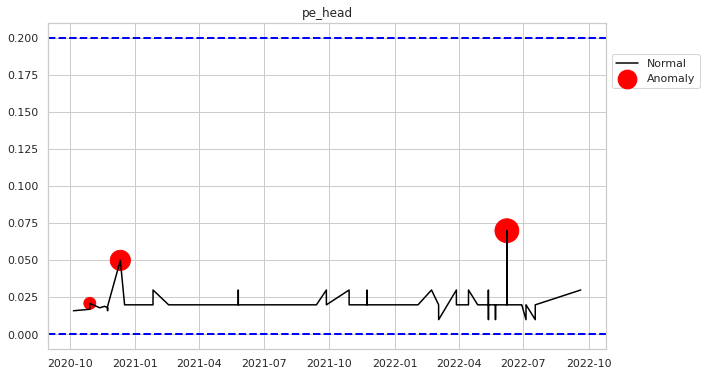

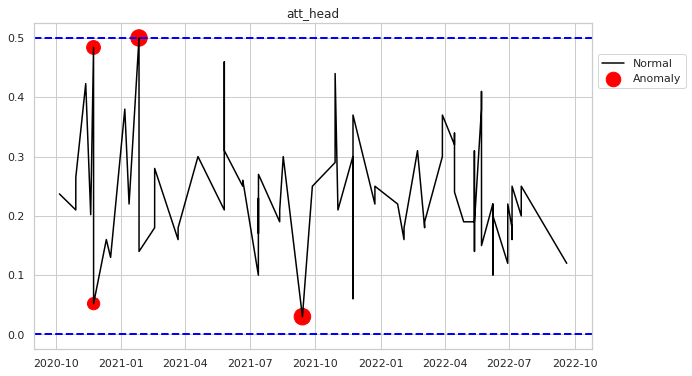

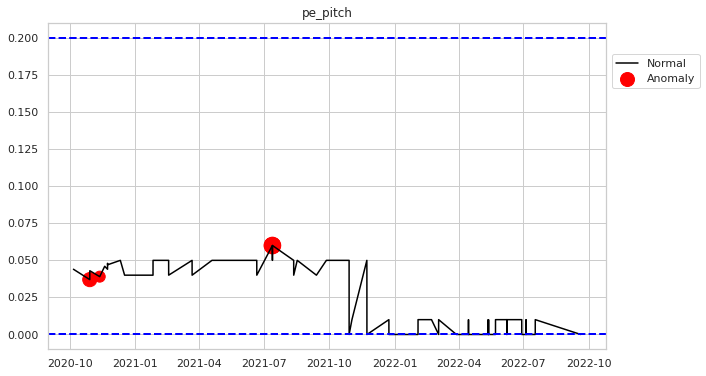

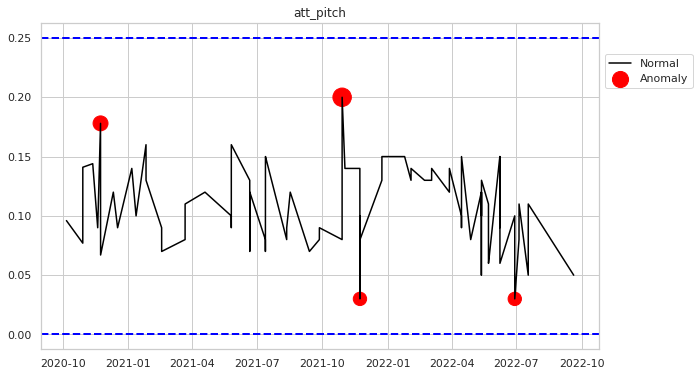

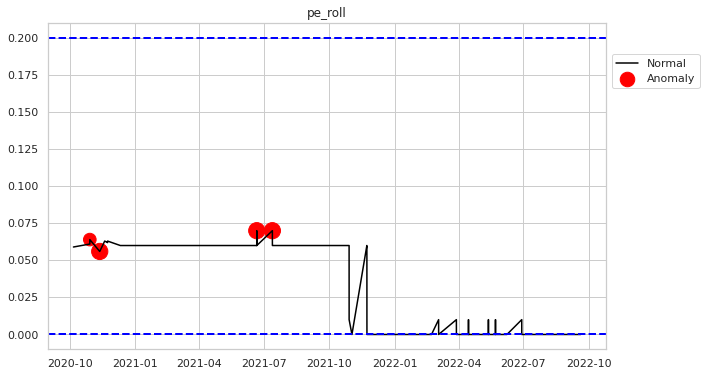

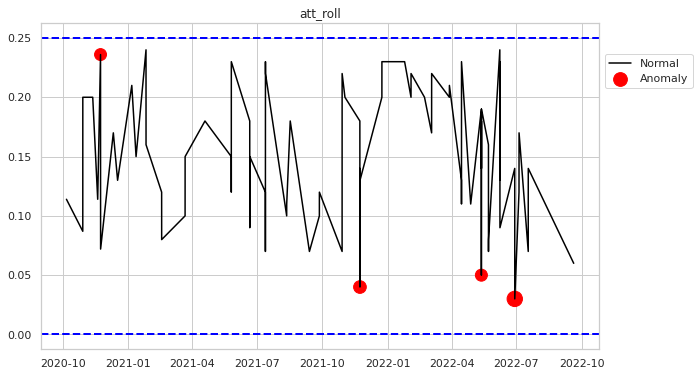

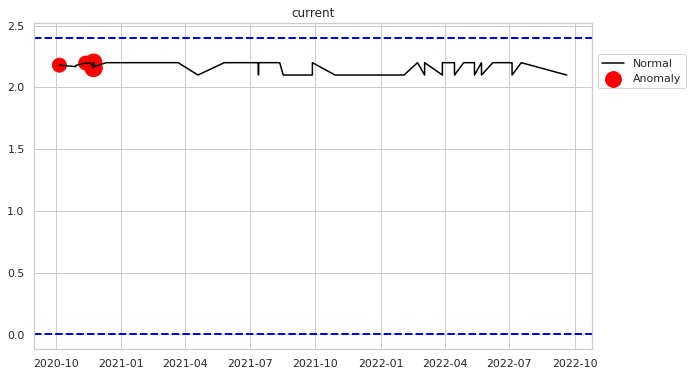

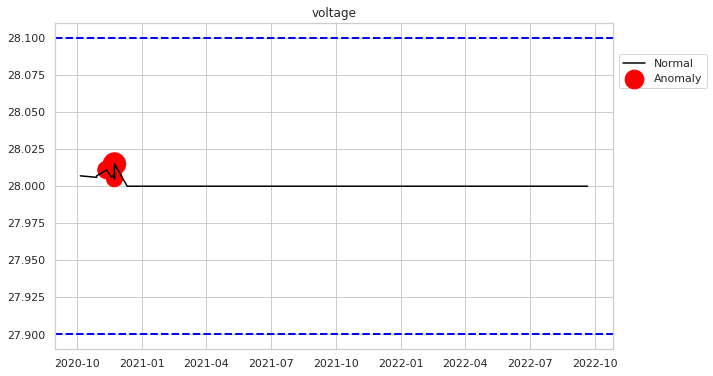

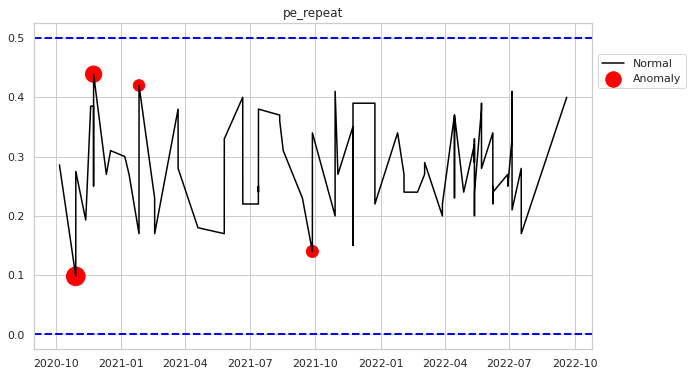

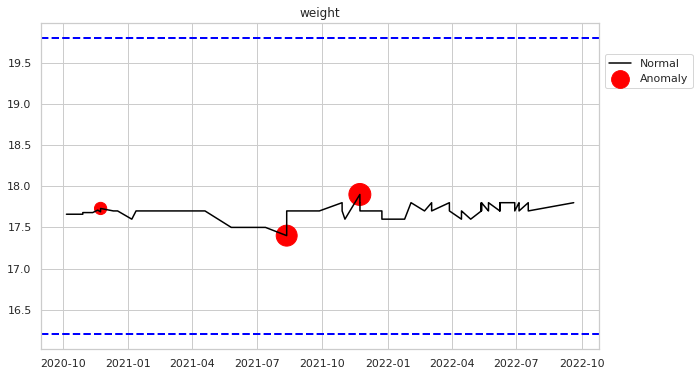

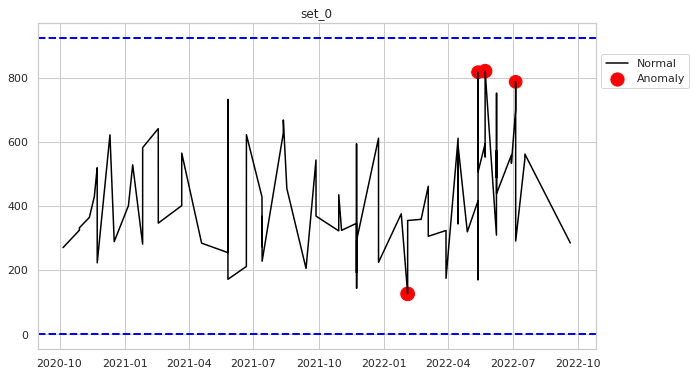

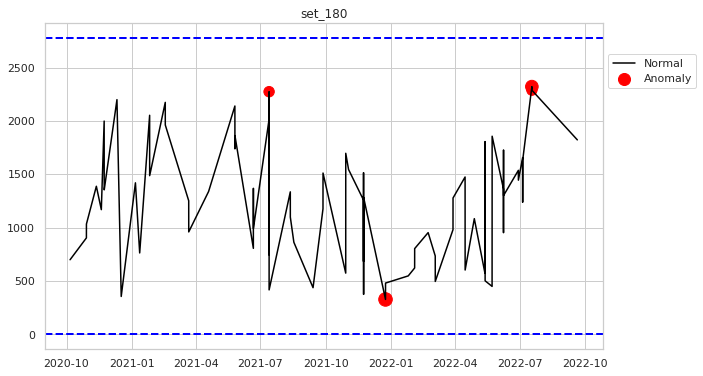

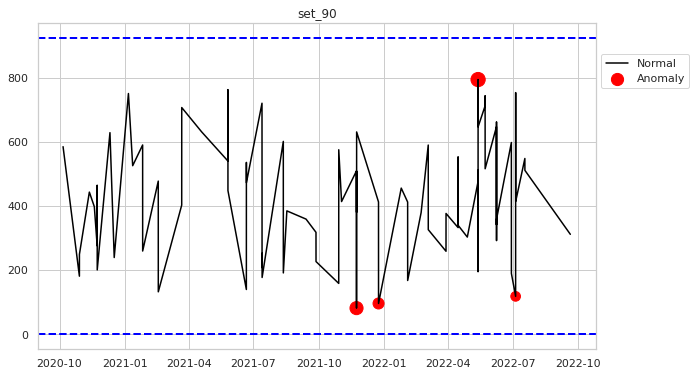

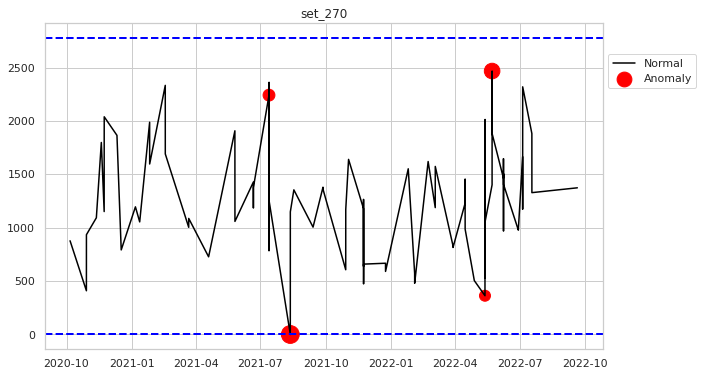

In [ ]:
# visualization
def IF_visualization(col_df, result_df):
  for col in col_df.columns[0:14]:
    fig, ax = plt.subplots(figsize=(10,6))
    inspct = result_df[result_df['col']==col].sort_index() #검사항목 별
    anomal_point = inspct.loc[inspct['pred_y']==-1, ['X']] #검사항목 별 이상치
    anomal_size = inspct.loc[inspct['pred_y']==-1]['score_samples']
    s = [((abs(n*10)**(5))/80) for n in anomal_size]

    up_lne = standard.loc[standard['검사항목']==col, ['상한값']].values[0][0]
    down_lne = standard.loc[standard['검사항목']==col, ['하한값']].values[0][0]

    ax.plot(inspct.index, inspct['X'], color='black', label = 'Normal')
    ax.scatter(anomal_point.index, anomal_point['X'], s=s, color='red', label = 'Anomaly')

    plt.axhline(up_lne, color='blue', linestyle='--', linewidth=2)
    plt.axhline(down_lne, color='blue', linestyle='--', linewidth=2)

    plt.legend(loc=(1.01, 0.8))
    plt.title(str(col))
    plt.show()

IF_visualization(df_num, isolation_result)

## (5) 분산 및 잔차

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
import statsmodels as sm
import statsmodels.api as sm

In [ ]:
df_num['date2num'] = dates.date2num(df_num['datetime_num'].values)
df_num = df_num[['pe_head', 'att_head', 'pe_pitch', 'att_pitch', 'pe_roll', 'att_roll', 'current', 'voltage', 'pe_repeat', 'weight', 'set_0', 'set_180', 'set_90', 'set_270', 'date2num', 'datetime_num',	'datetime']]

In [ ]:
# dates.num2date(df_num['date2num'].values)

In [ ]:
def least_square_line(x,f):
    b = (np.mean(x)*np.mean(f) - np.mean(x*f))/(np.mean(x)*np.mean(x)-np.mean(x*x))
    a = np.mean(f)-np.mean(x)*b
    return a,b

In [ ]:
def resid_fn(df): 
  resid_rslt = pd.DataFrame()

  for col in df.columns[:-1]:
    x = df['date2num'].values
    f = df[col].values

    a, b = least_square_line(x,f)
    # print(f'y = {a:.2f}+{b:.2f}x')
    
    ## |최소자승법 y|-|실제값 y|
    resid_list = [abs(abs(a+b*xi)-abs(fi)) for xi, fi in zip(x,f)]
    resid_rslt[col] = resid_list
  
  return resid_rslt

ols_resid = resid_fn(df_num.loc[:,'pe_head':'date2num'])

In [ ]:
ols_resid

,pe_head,att_head,pe_pitch,att_pitch,pe_roll,att_roll,current,voltage,pe_repeat,weight,set_0,set_180,set_90,set_270
0,0.005095,0.025834,0.013535,0.018169,0.018585,0.037706,0.000010,0.003682,0.004091,0.042062,103.831906,607.985118,181.608214,402.654945
1,0.004114,0.051118,0.018526,0.036648,0.013732,0.064462,0.011091,0.002834,0.183937,0.037983,52.617647,397.925098,224.129805,869.333272
2,0.000114,0.003885,0.012523,0.027353,0.010727,0.048539,0.001089,0.003834,0.006937,0.057976,44.983473,267.965152,155.702120,344.190534
3,0.003126,0.162926,0.015304,0.030669,0.016995,0.048687,0.018469,0.007926,0.088953,0.055501,14.814054,89.205654,37.699270,184.796123
4,0.002131,0.057552,0.007692,0.023172,0.009127,0.037239,0.019749,0.002973,0.103039,0.084260,48.957242,128.191470,8.180692,521.213951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.001618,0.055322,0.008092,0.000267,0.001432,0.005054,0.045462,0.000892,0.127340,0.069106,324.900236,82.774531,315.110324,64.985429
77,0.001618,0.034681,0.001904,0.010268,0.001437,0.025054,0.054536,0.000892,0.072660,0.030902,172.505590,476.184476,24.991992,1081.717310
78,0.011628,0.014356,0.000776,0.049439,0.003040,0.074808,0.045980,0.000978,0.002675,0.066808,82.388469,1169.167640,108.590280,644.766257
79,0.001628,0.035647,0.009227,0.010562,0.003045,0.004808,0.045982,0.000978,0.112675,0.033199,97.282643,1135.577586,71.587965,91.068995


In [ ]:
## 각 변수별 전체 잔차 합
ols_resid.apply(lambda x : abs(x).sum())

pe_head          0.325392
att_head         5.960396
pe_pitch         0.883679
att_pitch        2.352715
pe_roll          0.967622
att_roll         3.865651
current          3.436587
voltage          0.117603
pe_repeat        5.206009
weight           6.006199
set_0        11207.001737
set_180      35473.388046
set_90       12607.477596
set_270      34099.770636
dtype: float64

In [ ]:
def resid_visualization(df, col, result_df): 
  fig, ax = plt.subplots(figsize=(10,6))

  x = df['date2num'].values
  f = df[col].values
  a, b = least_square_line(x,f)

  ax.plot_date(x, f, color='black',linestyle='--')
  ax.plot(x, a+b*x)

  inspct = result_df[result_df['col']==col].sort_index() #검사항목 별
  anomal_point = inspct.loc[inspct['pred_y']==-1, ['X']] #검사항목 별 이상치
  ax.scatter(anomal_point.index, anomal_point['X'], s=100, c='red', label = 'Anomaly')

  plt.legend(loc=(1.01, 0.8))
  plt.title(col)

# resid_visualization(df_num, 'pe_head', isolation_result)

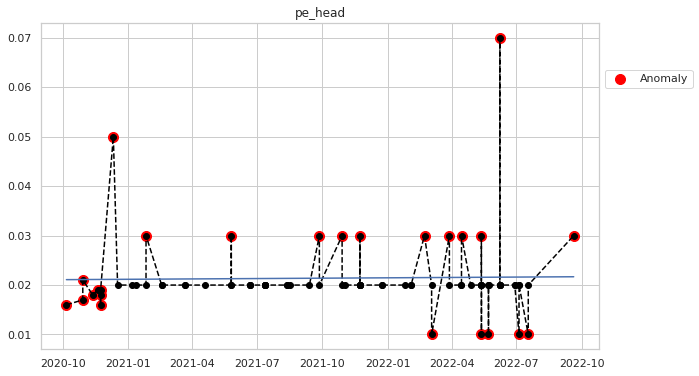

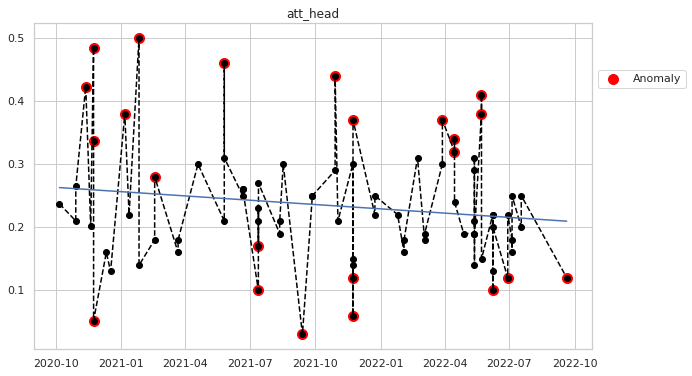

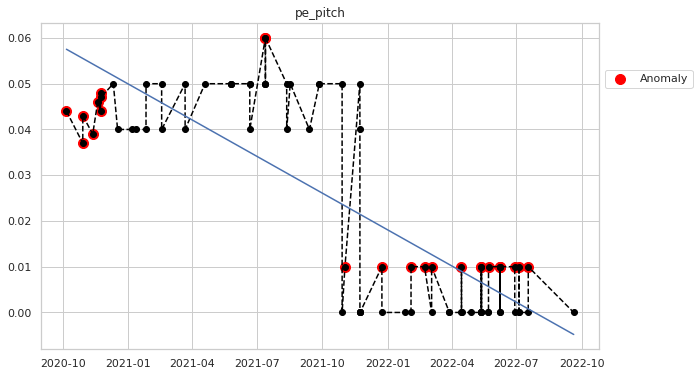

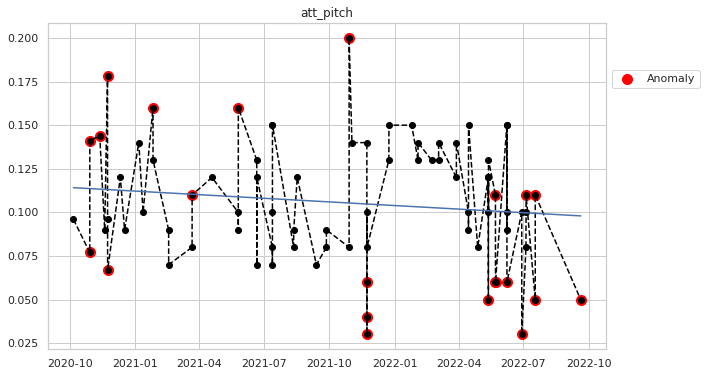

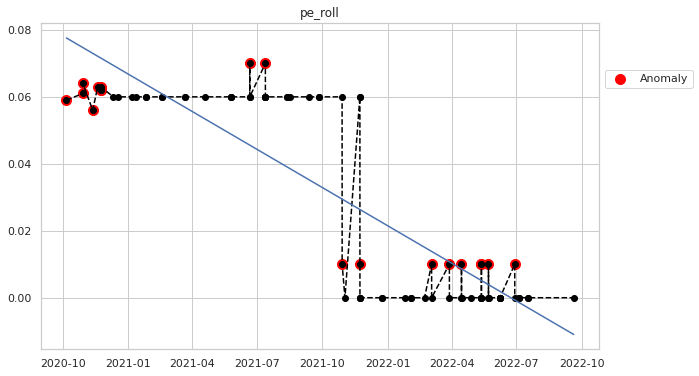

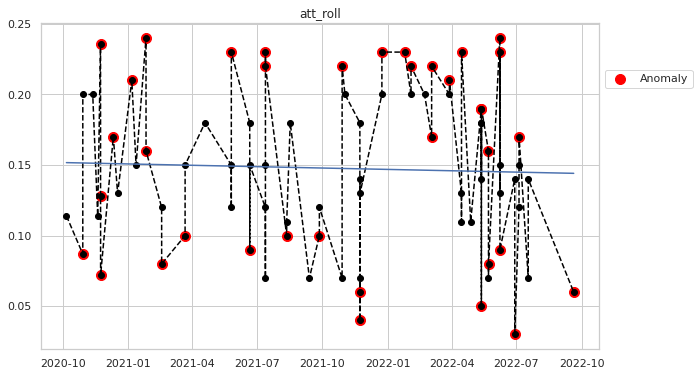

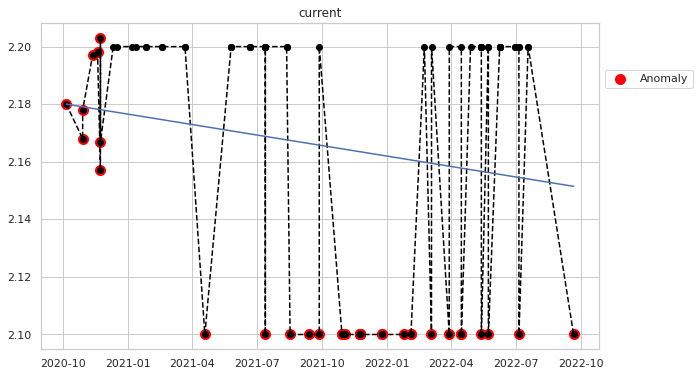

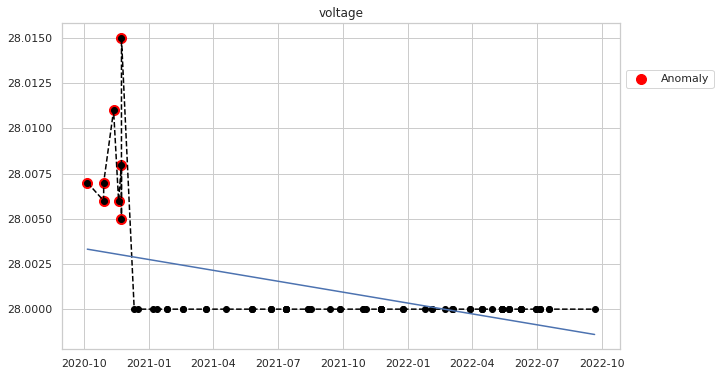

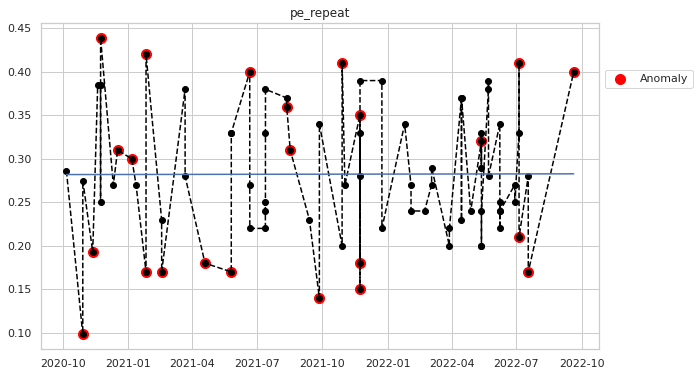

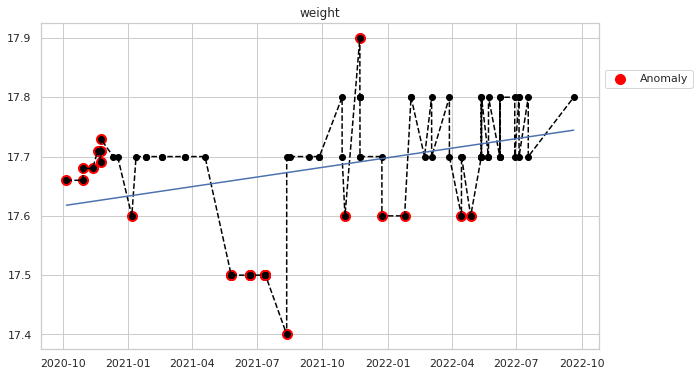

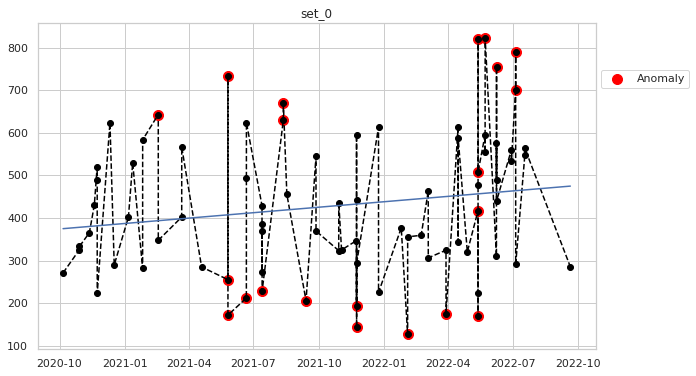

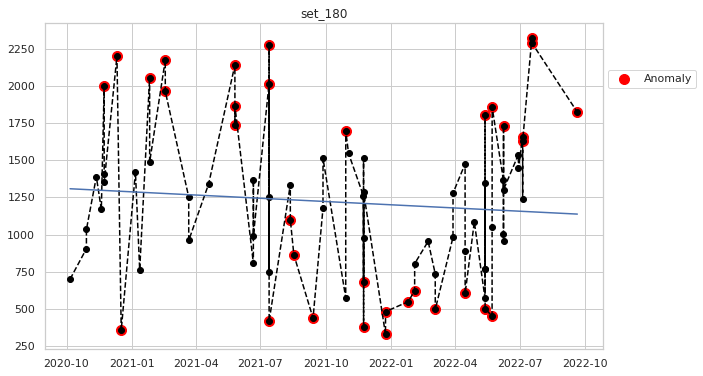

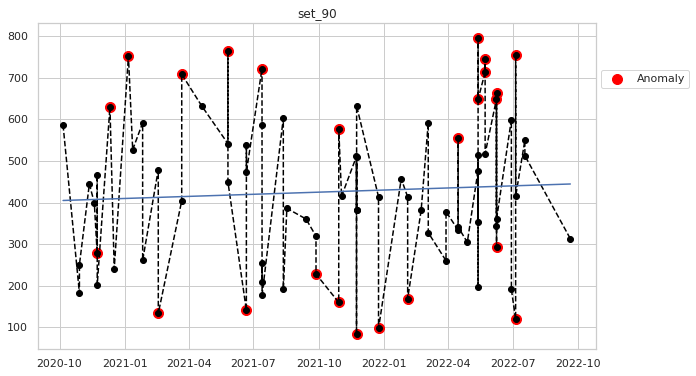

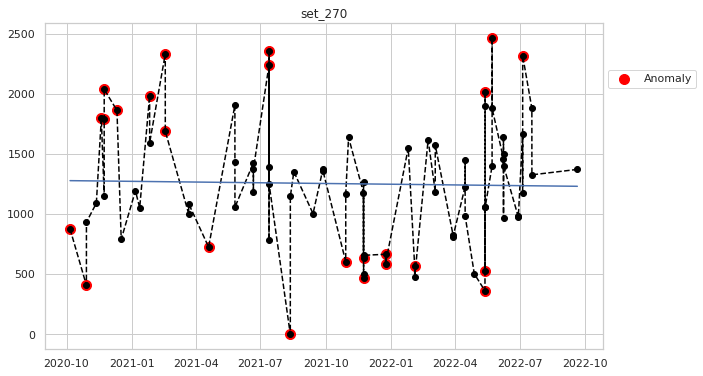

In [ ]:
for col in df_num.loc[:,'pe_head':'set_270'].columns:
  resid_visualization(df_num.loc[:,'pe_head':'date2num'], col, isolation_result)

## (6) 이상치가 기준에 가까운 정도

In [ ]:
def whole_standard_distance(df, stndrd):
  result = pd.DataFrame()

  for col in df['col'].unique():
    dstnc_list=[]

    for i in range(len(df[df['col']==col])):
      col_X = df[df['col']==col]['X'].values[i]

      up = stndrd[stndrd['검사항목']==col]['상한값'].values[0]
      low = stndrd[stndrd['검사항목']==col]['하한값'].values[0]

      if low == 0: #상기준만
        dstnc = up - col_X
      else: #상하 기준
        mu = col_X.mean()
        if col_X >= mu:
          dstnc = up - col_X
        else:
          dstnc = col_X - low
      
      dstnc_list.append(abs(dstnc))

    result[col] = dstnc_list

  return result

whl_stndrd_dstnc = whole_standard_distance(isolation_result, standard)
whl_stndrd_dstnc

,pe_head,att_head,pe_pitch,att_pitch,pe_roll,att_roll,current,voltage,pe_repeat,weight,set_0,set_180,set_90,set_270
0,0.184,0.263,0.156,0.154,0.141,0.136,0.220,0.093,0.214,2.14,654.700,2077.800,339.500,1900.200
1,0.183,0.290,0.163,0.173,0.139,0.163,0.232,0.094,0.402,2.14,600.270,1873.230,743.960,2368.390
2,0.179,0.235,0.157,0.109,0.136,0.050,0.222,0.093,0.225,2.12,592.630,1743.280,675.530,1843.250
3,0.182,0.077,0.161,0.106,0.144,0.050,0.203,0.089,0.307,2.12,560.509,1389.441,481.353,1684.773
4,0.181,0.298,0.154,0.160,0.137,0.136,0.202,0.094,0.115,2.09,495.759,1608.509,526.844,979.223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.180,0.340,0.190,0.150,0.200,0.100,0.200,0.100,0.090,2.00,136.900,1539.100,170.600,1604.400
77,0.180,0.250,0.200,0.140,0.200,0.080,0.300,0.100,0.290,2.10,634.300,1145.700,510.700,457.700
78,0.190,0.300,0.200,0.200,0.200,0.180,0.200,0.100,0.220,2.00,377.600,455.800,376.400,895.500
79,0.180,0.250,0.190,0.140,0.200,0.110,0.200,0.100,0.330,2.10,362.700,489.400,413.400,1449.200


In [ ]:
## 확인
# df_num.loc[:,'pe_head':'set_270'] + whl_stndrd_dstnc

In [ ]:
def abnrml_standard_distance(df, stndrd):
  result_abn = pd.DataFrame()
  dstnc_abnrml_list=[]
  col_list=[]
  idx_list=[]

  for col in df['col'].unique():
    mu = np.mean(df[df['col']==col]['X'].values)
    col_X_abnrml = df[(df['col']==col)&(df['pred_y']==-1)]['X'].values
    
    abnrml_index = df[(df['col']==col)&(df['pred_y']==-1)]['X'].index
    idx_list.extend(abnrml_index)

    up = stndrd[stndrd['검사항목']==col]['상한값'].values[0]
    low = stndrd[stndrd['검사항목']==col]['하한값'].values[0]

    for i in range(len(col_X_abnrml)):
      abnrml = col_X_abnrml[i]
      if low == 0:
        dstnc_abnrml = up - abnrml
      else:
        if abnrml >= mu:
          dstnc_abnrml = up - abnrml
        else:
          dstnc_abnrml = abnrml - low
      
      dstnc_abnrml_list.append(abs(dstnc_abnrml))
      col_list.append(col)

  result_abn['abnrml_dstnc'] = dstnc_abnrml_list
  result_abn['col'] = col_list
  result_abn.index = idx_list

  return result_abn

abnrml_standard_distance(isolation_result, standard)

,abnrml_dstnc,col
2020-10-06 00:00:00,0.184,pe_head
2020-10-29 00:00:00,0.183,pe_head
2020-10-29 01:00:00,0.179,pe_head
2020-11-12 00:00:00,0.182,pe_head
2020-11-19 00:00:00,0.181,pe_head
...,...,...
2022-05-13 00:00:00,2415.000,set_270
2022-05-13 02:00:00,2250.900,set_270
2022-05-13 04:00:00,763.600,set_270
2022-05-23 01:00:00,309.800,set_270


## (7) 응용 모델

### 333

In [ ]:
def _isolation_forest(df,columns,ratio):
  group_result = pd.DataFrame()
  
  group = df[[columns, 'datetime_num']].set_index('datetime_num')
  outliers_fraction = float(ratio) # 이상치 비율설정

  #표준화
  scaler = StandardScaler()
  np_scaled = scaler.fit_transform(group.values.reshape(-1, 1))
  data = pd.DataFrame(np_scaled)

  # 학습 및 예측
  model = IsolationForest(contamination=outliers_fraction)
  IF_model = model.fit(data)

  group_result.index = group.index
  group_result['X'] = group[columns]
  group_result['score_samples'] = model.score_samples(data)
  
  group_result['pred_y'] = model.predict(data)
  group_result['decision_function'] = model.decision_function(data)
  group_result['score_samples'] = model.score_samples(data)
  group_result['offset'] = model.decision_function(data) - model.score_samples(data)
  group_result['col'] = str(columns)

  return group_result

### smoothing tool

In [ ]:
def moving_avarage_smoothing(X,k): # k=window size
	S = np.zeros(X.shape[0])
	for t in range(X.shape[0]):
		if t < k:
			S[t] = np.median(X[:t+1])
		else:
			S[t] = np.sum(X[t-k:t])/k
	return S

def exponential_smoothing(X,a):
	S = np.zeros(X.shape[0])
	S[0] = X[0]
	for t in range(1,X.shape[0]):
		S[t] = a * X[t-1] + (1- a) * S[t-1]
	return S

Text(0.5, 1.0, 'pe_head (savgol_filter)')

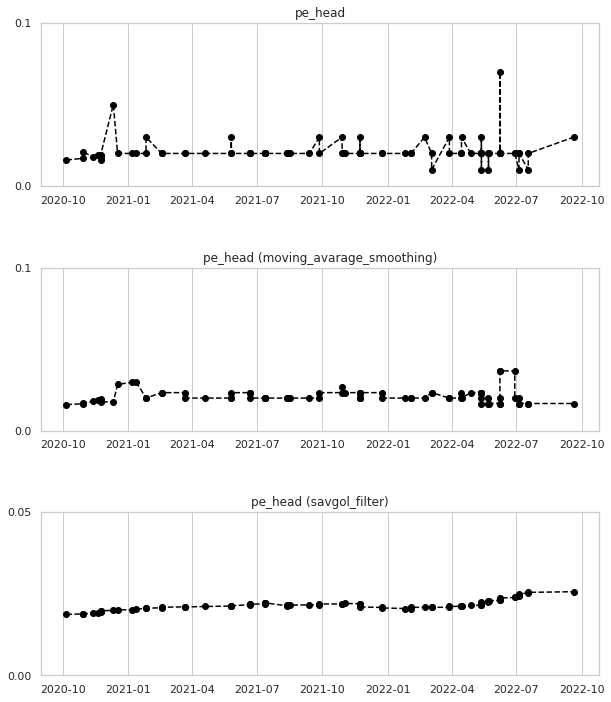

In [ ]:
fig, ax = plt.subplots(figsize=(10,12), nrows=3)
plt.subplots_adjust(hspace=0.5)
x = df_num['date2num'].values

f1 = df_num['pe_head'].values
f2 = moving_avarage_smoothing(df_num['pe_head'], 3)
f3 = signal.savgol_filter(df_num['pe_head'], window_length=81, polyorder=3, mode="constant", cval=df_num['pe_head'].mean())
f3 = signal.savgol_filter(df_num['pe_head'], window_length=81, polyorder=3, mode="nearest")

ax[0].plot_date(x, f1, color='black',linestyle='--')
ax[0].set_yticks([0, 0.1])
ax[0].set_title("pe_head")

ax[1].plot_date(x, f2, color='black',linestyle='--')
ax[1].set_yticks([0, 0.1])
ax[1].set_title("pe_head (moving_avarage_smoothing)")

ax[2].plot_date(x, f3, color='black',linestyle='--')
ax[2].set_yticks([0, 0.05])
ax[2].set_title("pe_head (savgol_filter)")

Text(0.5, 1.0, 'pe_head (wrap)')

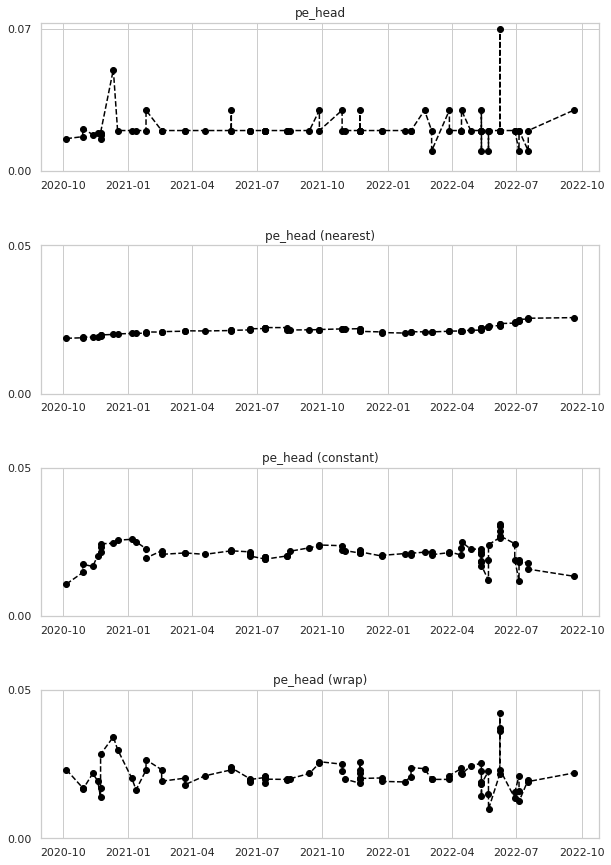

In [ ]:
fig, ax = plt.subplots(figsize=(10,15), nrows=4)
plt.subplots_adjust(hspace=0.5)
x = df_num['date2num'].values

f1 = df_num['pe_head'].values
f2 = signal.savgol_filter(df_num['pe_head'], window_length=79, polyorder=3, mode="nearest")
f3 = signal.savgol_filter(df_num['pe_head'], window_length=11, polyorder=3, mode="constant", cval=0)
f4 = signal.savgol_filter(df_num['pe_head'], window_length=23, polyorder=15, mode="wrap")

ax[0].plot_date(x, f1, color='black',linestyle='--')
ax[0].set_yticks([0, 0.07])
ax[0].set_title("pe_head")

ax[1].plot_date(x, f2, color='black',linestyle='--')
ax[1].set_yticks([0, 0.05])
ax[1].set_title("pe_head (nearest)")

ax[2].plot_date(x, f3, color='black',linestyle='--')
ax[2].set_yticks([0, 0.05])
ax[2].set_title("pe_head (constant)")

ax[3].plot_date(x, f4, color='black',linestyle='--')
ax[3].set_yticks([0, 0.05])
ax[3].set_title("pe_head (wrap)")

In [ ]:
def pnlty_data_isolation_forest(df,columns,ratio, pnlty_df):
  group_result = pd.DataFrame()
  
  group = df[[columns, 'datetime_num']].set_index('datetime_num')
  # pnlty = pnlty_df[[columns]]
  outliers_fraction = float(ratio) # 이상치 비율설정

  #표준화
  scaler = StandardScaler()
  np_scaled = scaler.fit_transform(group.values.reshape(-1, 1))
  # pnlty_np_scaled = scaler.fit_transform(pnlty.values.reshape(-1, 1))

  # data = moving_avarage_smoothing(np_scaled, 10)
  data = signal.savgol_filter(df_num['pe_head'], window_length=81, polyorder=3, mode="nearest")

  X_data = pd.DataFrame(data)
  # pnlty_data = pd.DataFrame(pnlty_np_scaled)

  # 학습 및 예측
  model = IsolationForest(contamination='auto')
  IF_model = model.fit(X_data)

  group_result.index = group.index
  group_result['X'] = group[columns]
  group_result['pred_y'] = model.predict(X_data)
  group_result['decision_function'] = model.decision_function(X_data)
  group_result['score_samples'] = model.score_samples(X_data)
  group_result['offset'] = model.decision_function(X_data) - model.score_samples(X_data)
  group_result['col'] = str(columns)

  return group_result

In [ ]:
pnlty_isolation_result = pd.DataFrame()

for col in df_num.columns[0:14]:
  df_col = pd.DataFrame()
  df_col = pnlty_data_isolation_forest(df_num, col, .05, whl_stndrd_dstnc)

  pnlty_isolation_result = pd.concat([pnlty_isolation_result,df_col], axis=0)

pnlty_isolation_result

,X,pred_y,decision_function,score_samples,offset,col
datetime_num,,,,,,
2020-10-06 00:00:00,0.016,-1,-0.192387,-0.692387,0.5,pe_head
2020-10-29 00:00:00,0.017,-1,-0.086840,-0.586840,0.5,pe_head
2020-10-29 01:00:00,0.021,-1,-0.086840,-0.586840,0.5,pe_head
2020-11-12 00:00:00,0.018,-1,-0.103440,-0.603440,0.5,pe_head
2020-11-19 00:00:00,0.019,-1,-0.086942,-0.586942,0.5,pe_head
...,...,...,...,...,...,...
2022-07-05 01:00:00,1173.600,-1,-0.100973,-0.600973,0.5,set_270
2022-07-05 02:00:00,2320.300,-1,-0.122274,-0.622274,0.5,set_270
2022-07-18 00:00:00,1882.500,-1,-0.121490,-0.621490,0.5,set_270


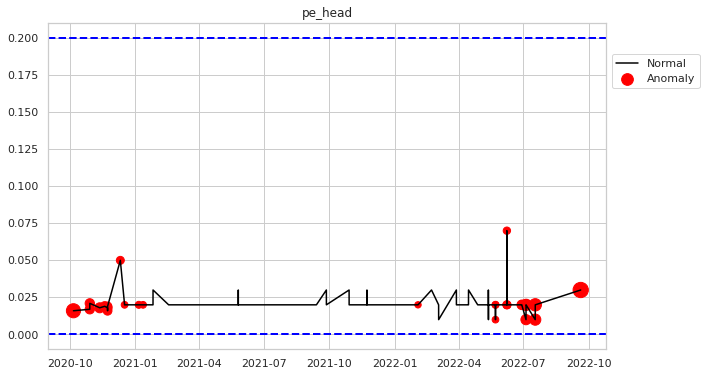

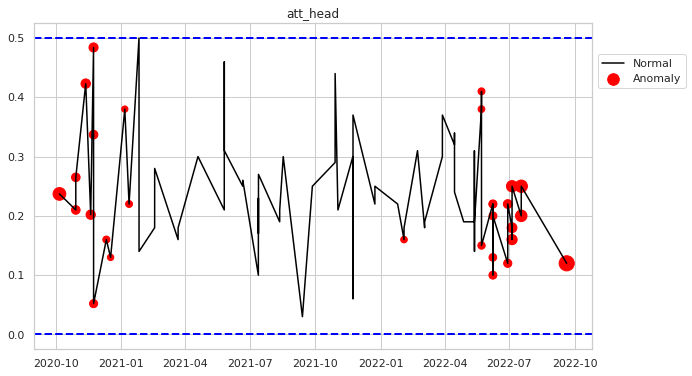

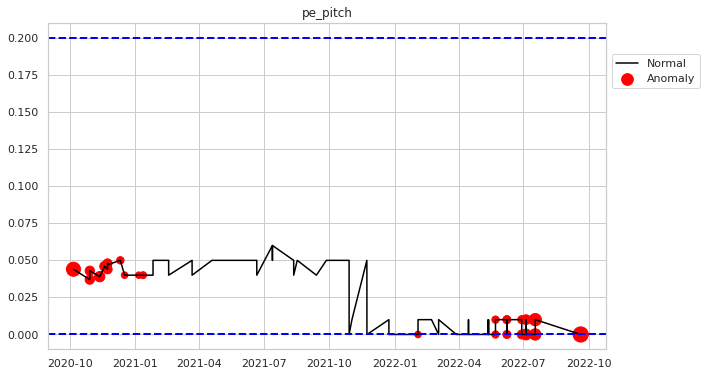

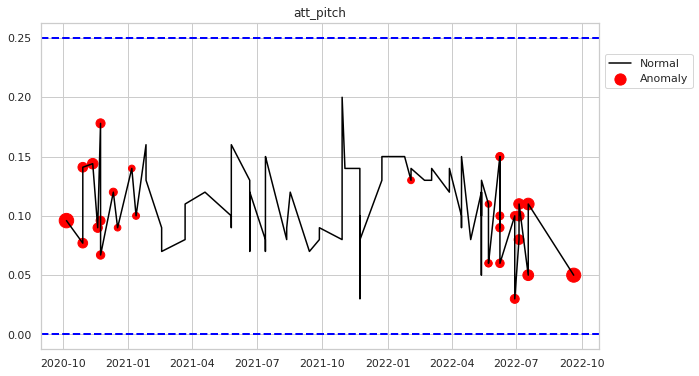

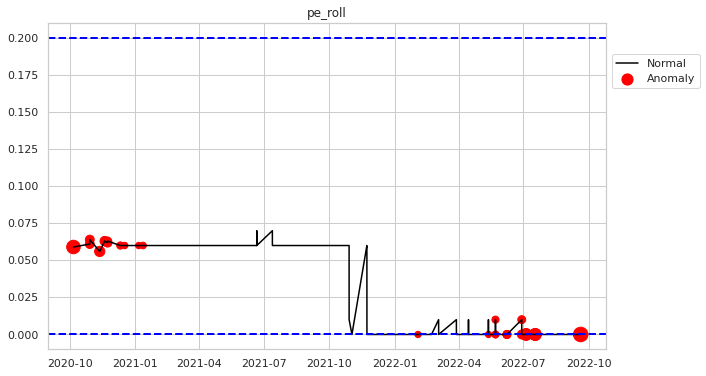

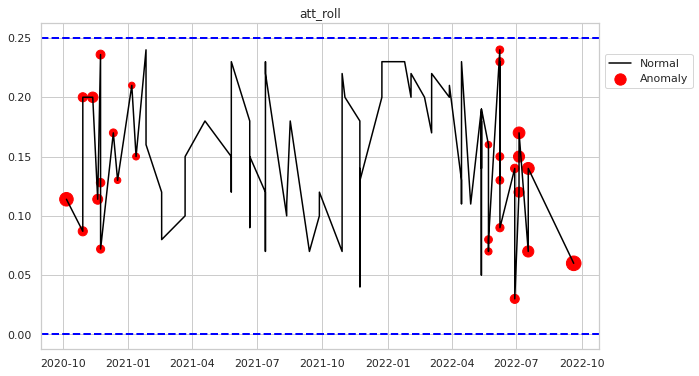

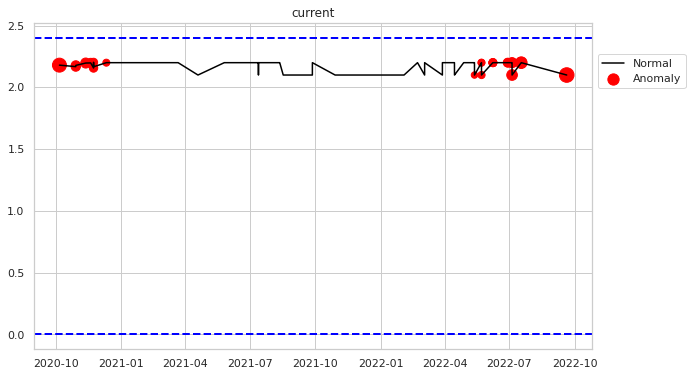

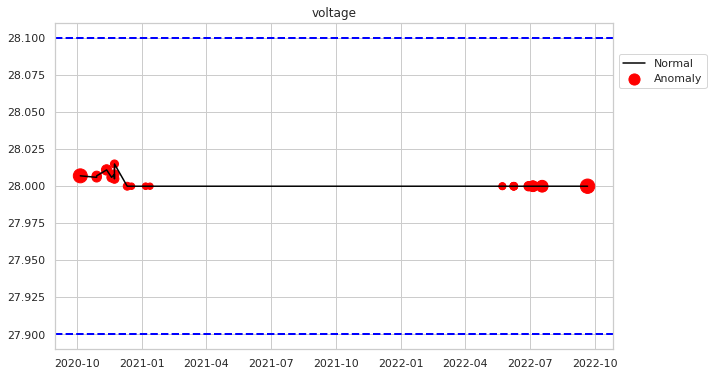

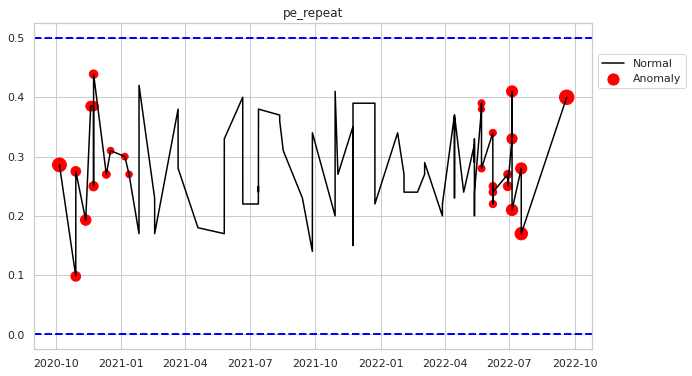

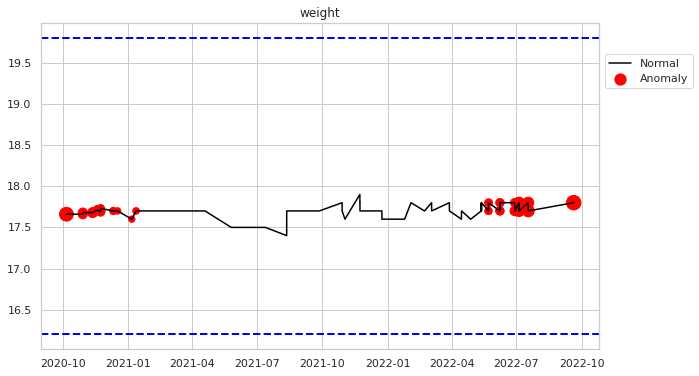

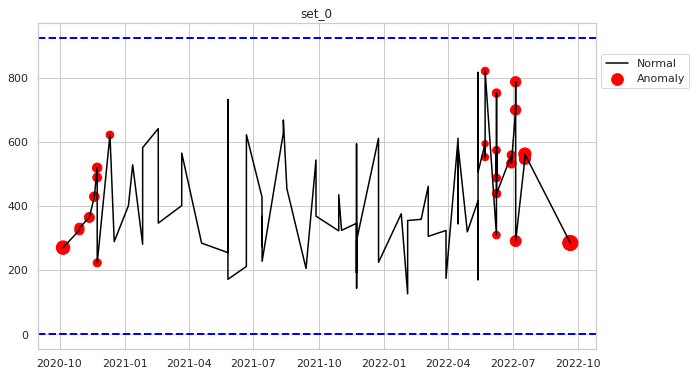

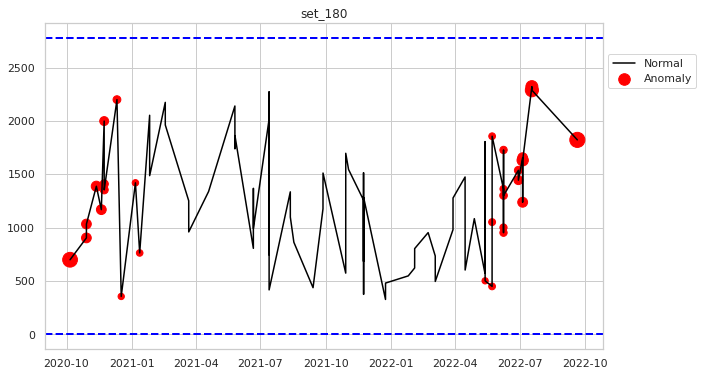

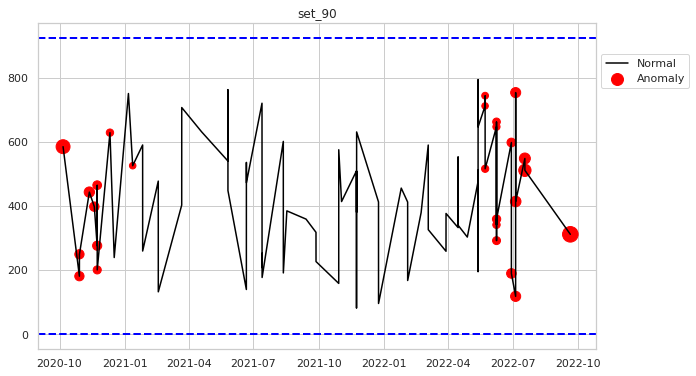

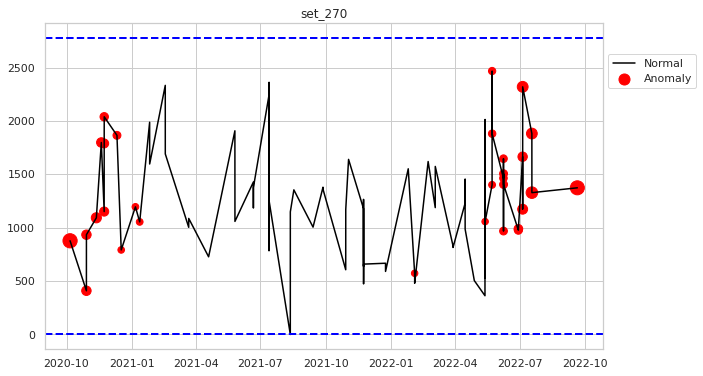

In [ ]:
# visualization
IF_visualization(df_num, pnlty_isolation_result)

In [ ]:
IF_visualization(df_num, isolation_result)

In [ ]:
print(pnlty_isolation_result[(pnlty_isolation_result['col']=='pe_head')&(pnlty_isolation_result['pred_y']==1)]['score_samples'].mean())
pnlty_isolation_result[pnlty_isolation_result['col']=='pe_head'].sort_values(by='score_samples')

-0.4268171326524184


,X,pred_y,decision_function,score_samples,col
datetime_num,,,,,
2022-09-20 00:00:00,0.030,-1,-0.202989,-0.702989,pe_head
2020-10-06 00:00:00,0.016,-1,-0.197846,-0.697846,pe_head
2022-07-18 01:00:00,0.020,-1,-0.144671,-0.644671,pe_head
2020-11-12 00:00:00,0.018,-1,-0.128904,-0.628904,pe_head
2022-07-05 02:00:00,0.020,-1,-0.122172,-0.622172,pe_head
...,...,...,...,...,...
2022-02-22 00:00:00,0.030,1,0.098357,-0.401643,pe_head
2022-03-04 00:00:00,0.020,1,0.098357,-0.401643,pe_head
2021-02-17 01:00:00,0.020,1,0.098679,-0.401321,pe_head


## (4) odds ratio

- 오즈(odds):  (사건 A가 일어날 확률) / (사건 A가 일어나지 않을 확률)

  $Odds = \frac{P}{1-P}$

In [ ]:
def odds_fn(P):
  return (P)/(1-P)

In [ ]:
isolation_result

,X,pred_y,decision_function,score_samples,col
datetime_num,,,,,
2020-10-06 00:00:00,0.016,-1,-0.095228,-0.595228,pe_head
2020-10-29 00:00:00,0.017,-1,-0.108714,-0.608714,pe_head
2020-10-29 01:00:00,0.021,-1,-0.126915,-0.626915,pe_head
2020-11-12 00:00:00,0.018,-1,-0.050355,-0.550355,pe_head
2020-11-19 00:00:00,0.019,-1,-0.021271,-0.521271,pe_head
...,...,...,...,...,...
2022-07-05 01:00:00,1173.600,1,0.088720,-0.411280,set_270
2022-07-05 02:00:00,2320.300,-1,-0.067401,-0.567401,set_270
2022-07-18 00:00:00,1882.500,1,0.021753,-0.478247,set_270


In [ ]:
## 이상치 개수(score_samples)

def odds_ratio_result(col_df, result_df):
  odds_result = pd.DataFrame()
  odds_raito_result = pd.DataFrame()
  odds_list=[]

  for col in col_df.columns[0:14]:
    inspct = result_df[result_df['col']==col].sort_index() #검사항목 별
    anomal_point = inspct.loc[inspct['pred_y']==-1, ['X']] #검사항목 별 이상치
    anomal_size = inspct.loc[inspct['pred_y']==-1]['score_samples']

    ##odds
    risk_P = len(anomal_point)/len(inspct)
    odds = odds_fn(risk_P)
    odds_result[col] = [odds]

  ##odds ratio
  for i in range(len(odds_result.columns)):
    odds_list = [odds_result.iloc[0,i]/(odds_result.iloc[0,j]) for j in range(len(odds_result.columns))]
    odds_raito_result[odds_result.columns[i]] = odds_list
  odds_raito_result.index = odds_result.columns

  return odds_raito_result

odds_ratio_result(df_num, isolation_result)

,pe_head,att_head,pe_pitch,att_pitch,pe_roll,att_roll,current,voltage,pe_repeat,weight,set_0,set_180,set_90,set_270
pe_head,1.000000,0.888276,1.000000,0.835254,0.686452,1.883636,1.704348,0.245479,0.888276,1.120000,0.784000,1.620426,0.943158,0.943158
att_head,1.125776,1.000000,1.125776,0.940310,0.772791,2.120553,1.918715,0.276355,1.000000,1.260870,0.882609,1.824237,1.061785,1.061785
pe_pitch,1.000000,0.888276,1.000000,0.835254,0.686452,1.883636,1.704348,0.245479,0.888276,1.120000,0.784000,1.620426,0.943158,0.943158
att_pitch,1.197240,1.063480,1.197240,1.000000,0.821848,2.255165,2.040514,0.293898,1.063480,1.340909,0.938636,1.940039,1.129187,1.129187
pe_roll,1.456767,1.294011,1.456767,1.216771,1.000000,2.744019,2.482838,0.357606,1.294011,1.631579,1.142105,2.360582,1.373961,1.373961
att_roll,0.530888,0.471575,0.530888,0.443426,0.364429,1.000000,0.904818,0.130322,0.471575,0.594595,0.416216,0.860265,0.500711,0.500711
current,0.586735,0.521182,0.586735,0.490073,0.402765,1.105195,1.000000,0.144031,0.521182,0.657143,0.460000,0.950760,0.553383,0.553383
voltage,4.073661,3.618534,4.073661,3.402542,2.796371,7.673295,6.942935,1.000000,3.618534,4.562500,3.193750,6.601064,3.842105,3.842105
pe_repeat,1.125776,1.000000,1.125776,0.940310,0.772791,2.120553,1.918715,0.276355,1.000000,1.260870,0.882609,1.824237,1.061785,1.061785
weight,0.892857,0.793103,0.892857,0.745763,0.612903,1.681818,1.521739,0.219178,0.793103,1.000000,0.700000,1.446809,0.842105,0.842105


In [ ]:
## 이상치 정도(score_samples)

def odds_ratio_score_result(col_df, result_df):
  odds_result = pd.DataFrame()
  odds_raito_result = pd.DataFrame()
  odds_list=[]

  for col in col_df.columns[0:14]:
    inspct = result_df[result_df['col']==col].sort_index() #검사항목 별

    inspct_score = np.sum(np.abs(inspct['score_samples'].values))
    anomal_score = np.sum(np.abs(inspct.loc[inspct['pred_y']==-1]['score_samples'].values))

    ##odds
    risk_P = anomal_score/inspct_score
    odds = odds_fn(risk_P)
    odds_result[col] = [odds]

  ##odds ratio
  for i in range(len(odds_result.columns)):
    odds_list = [odds_result.iloc[0,i]/(odds_result.iloc[0,j]) for j in range(len(odds_result.columns))]
    odds_raito_result[odds_result.columns[i]] = odds_list
  odds_raito_result.index = odds_result.columns

  return odds_raito_result

odds_ratio_score_result(df_num, isolation_result) #칼럼:분자, 인덱스:분모 -> pe_head가 att_head보다 이상치가 발생할 확률

,pe_head,att_head,pe_pitch,att_pitch,pe_roll,att_roll,current,voltage,pe_repeat,weight,set_0,set_180,set_90,set_270
pe_head,1.000000,0.624931,0.661885,0.589205,0.531188,1.206223,1.379332,0.213717,0.586920,0.921067,0.517557,1.032425,0.603879,0.628137
att_head,1.600177,1.000000,1.059134,0.942833,0.849994,1.930169,2.207175,0.341985,0.939176,1.473870,0.828182,1.652062,0.966313,1.005130
pe_pitch,1.510836,0.944168,1.000000,0.890192,0.802537,1.822404,2.083944,0.322891,0.886740,1.391581,0.781943,1.559824,0.912361,0.949012
att_pitch,1.697201,1.060634,1.123353,1.000000,0.901532,2.047203,2.341004,0.362721,0.996122,1.563237,0.878398,1.752233,1.024904,1.066075
pe_roll,1.882574,1.176479,1.246048,1.109223,1.000000,2.270803,2.596695,0.402338,1.104920,1.733977,0.974339,1.943616,1.136846,1.182515
att_roll,0.829034,0.518089,0.548726,0.488471,0.440373,1.000000,1.143514,0.177179,0.486577,0.763596,0.429072,0.855916,0.500636,0.520747
current,0.724988,0.453068,0.479859,0.427167,0.385105,0.874498,1.000000,0.154942,0.425510,0.667763,0.375223,0.748496,0.437805,0.455392
voltage,4.679085,2.924105,3.097018,2.756942,2.485472,5.644019,6.454013,1.000000,2.746249,4.309753,2.421692,4.830805,2.825600,2.939107
pe_repeat,1.703809,1.064763,1.127727,1.003894,0.905043,2.055174,2.350119,0.364133,1.000000,1.569323,0.881818,1.759055,1.028894,1.070226
weight,1.085697,0.678486,0.718607,0.639698,0.576709,1.309592,1.497537,0.232032,0.637217,1.000000,0.561910,1.120901,0.655629,0.681967
